# Attention Architecture

Looks like transformer requires really large bptt, otherwise it seems to diverge

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [3]:
bs = 32
bptt = 128

In [4]:
# PATH=Path('data/wikitext-2-raw')
# data = TextLMDataBunch.load(PATH, cache_name='tmp_200', bs=bs, bptt=bptt)

In [5]:
# defaults.text_spec_tok = [PAD,UNK,BOS,FLD,TK_MAJ,TK_UP,TK_REP,TK_WREP]

In [6]:
PATH=Path('data/wikitext-2')
# data = TextLMDataBunch.load(PATH, cache_name='tmp_rev', bs=bs, bptt=bptt)
data = TextLMDataBunch.load(PATH, bs=bs, bptt=bptt)

In [7]:
# epoch = 1
# lr = 1e-3
momentum = (0.8,0.7)
weight_decay = 1.2e-6

In [8]:
vocab = data.train_ds.vocab
vocab_sz = len(vocab.itos); vocab_sz

29172

In [9]:
t = data.train_ds[0][0]
t.text[:50], t.data

('xxbos = xxmaj valkyria xxmaj chronicles xxup iii =',
 array([   2,   16,    4, 3792,    4, 3857,    5,  884,   16]))

In [10]:
ob = data.one_batch(); ob[1].shape

torch.Size([32, 128])

In [11]:
sum(ob[0]==vocab.stoi[PAD])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.uint8)

In [12]:
vocab.textify(ob[0][0])

'xxbos 38th xxmaj ranger xxmaj battalion xxbos xxmaj the xxmaj amylostereaceae are white rot pathogens . xxmaj they xxunk the lignin of the host wood , whereby the infested wood parts become less stable and take a fibrous structure . xxmaj the wood xxunk as fungal enzymes break down and remove the brown - xxunk lignin . xxmaj the distribution in wood takes place mainly along the transport channels in the xxunk . xxmaj if the wood is xxunk , the red rot is vertically positioned , on which xxunk , infested areas contrast with intact wood . xxmaj symptoms of xxunk by the symbiotic partner — wood wasps — include circular exit holes in the crust and acute stress through xxunk , common in hanging , falling'

In [13]:
data.show_batch()

idx,text
0,"xxbos 38th xxmaj ranger xxmaj battalion xxbos xxmaj the xxmaj amylostereaceae are white rot pathogens . xxmaj they xxunk the lignin of the host wood , whereby the infested wood parts become less stable and take a fibrous structure . xxmaj the wood xxunk as fungal enzymes break down and remove the brown - xxunk lignin . xxmaj the distribution in wood takes place mainly along the transport channels in"
1,"the biological parents of her adopted daughter xxmaj beth , to be a part of xxmaj beth 's life . xxmaj the director of xxmaj new xxmaj directions , xxmaj will xxmaj schuester ( xxmaj matthew xxmaj morrison ) sets up a "" booty camp "" for the less capable dancers in the club , and auditions for the school musical , xxmaj west xxmaj side xxmaj story , begin"
2,"appeared to be suffering a minor nervous breakdown . xxmaj political leaders urged xxmaj lady xxmaj rosebery to influence him , but she defended his decision , while stressing that his deterioration in health was only temporary . xxmaj she had to be careful — if it appeared her husband had declined the offer on the grounds that it was too xxunk , it would give substance to the claims"
3,"an unnamed xxmaj kimmeridgian ( xxmaj late xxmaj jurassic ) formation in xxunk - de - xxmaj calais , xxmaj france , is actually a xxunk , sometimes assigned to xxunk , although the two come from different formations . xxbos xxmaj angelou 's recitation of "" xxmaj on the xxmaj pulse of xxmaj morning "" resulted in more fame and recognition for her previous works , and xxunk her"
4,"pope 's xxmaj hill , then at the top of xxmaj walker 's xxmaj ridge . xxmaj it was not a large beachhead ; it was under two miles ( 3.2 km ) in length , with a depth around 790 yards ( 720 m ) , and in places only a few yards separated the two sides . xxmaj that evening xxmaj birdwood had been ashore to check on"


In [14]:
from fastai.callbacks import RNNTrainer
class TransformerTrainer(LearnerCallback):
    def __init__(self, learn, bptt:int, adjust:bool=True):
        super().__init__(learn)
        self.bptt,self.adjust = bptt,adjust
        
    def on_train_begin(self, **kwargs):
        "IN LM, put the training dataloader `first` attribute to `True` to avoid OOM."
        if hasattr(self.learn.data.train_dl, 'first'):
            self.learn.data.first = True
            
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        position_ids = torch.arange(last_input.shape[-1], dtype=torch.long, device=last_input.device) + 1
        position_ids = position_ids.unsqueeze(0).expand_as(last_input)
        
        if not train and len(last_target.shape) == 1:
#             return [1],[123]
            return (last_input, position_ids, last_input[:, 1:], position_ids[:, 1:]), last_target
        target_ids = torch.arange(last_target.shape[-1], dtype=torch.long, device=last_target.device) + 1
        target_ids = target_ids.unsqueeze(0).expand_as(last_target)
        
        ## STUPID TEST TO SEE IF IT CAN EVEN PREDICT ITSELF
#         return (last_input, position_ids, last_target, target_ids), last_target[:, :-1]
        return (last_input, position_ids, last_target, target_ids), last_target[:, 1:]
    
    def on_backward_begin(self, last_loss:Rank0Tensor, last_input:Tensor, **kwargs):
        "Adjusts the lr to the sequence length and applies AR and TAR to `last_loss`."
        if self.adjust: self.learn.opt.lr *= last_input.size(1) / self.bptt
        return last_loss


### Transformer Arch
Paper: https://arxiv.org/abs/1706.03762  
Inspiration: https://github.com/jadore801120/attention-is-all-you-need-pytorch

In [15]:
import transformer.Constants as Constants
# from dataset import TranslationDataset, paired_collate_fn
from transformer.Models import Transformer
from transformer.Optim import ScheduledOptim

In [16]:
transformer = Transformer(
    n_src_vocab=vocab_sz,
    n_tgt_vocab=vocab_sz,
    len_max_seq=data.bptt+data.max_len,
    padding_idx=vocab.stoi[PAD]
#     len_max_seq=opt.max_token_seq_len,
#     tgt_emb_prj_weight_sharing=False,
#     emb_src_tgt_weight_sharing=False,
#     d_k=opt.d_k,
#     d_v=opt.d_v,
#     d_model=opt.d_model,
#     d_word_vec=opt.d_word_vec,
#     d_inner=opt.d_inner_hid,
#     n_layers=opt.n_layers,
#     n_head=opt.n_head,
#     dropout=opt.dropout
)

In [17]:
transformer.reset = lambda: None

### Create Language learner

Currently model is completely diverging

In [18]:
class TransformerLanguageLearner(LanguageLearner):
    def predict(self, text:str, n_words:int=1, no_unk:bool=True, temperature:float=1., min_p:float=None):
        "Return the `n_words` that come after `text`."
        ds = self.data.single_dl.dataset
#         self.model.reset()
        for _ in progress_bar(range(n_words), leave=False):
            xb, yb = self.data.one_item(text)
            res = self.pred_batch(batch=(xb,yb))[-1]
            if no_unk: res[self.data.vocab.stoi[UNK]] = 0.
            if min_p is not None: res[res < min_p] = 0.
            if temperature != 1.: res.pow_(1 / temperature)
            idx = torch.multinomial(res, 1).item()
            text += f' {self.data.vocab.itos[idx]}'
        return text

In [19]:
learn = TransformerLanguageLearner(data, transformer, 
                        bptt=bptt)
#                         bptt=bptt, clip=0.3)




In [20]:
rt = learn.callbacks[0]
learn.callbacks = [
    TransformerTrainer(learn, bptt=rt.bptt, adjust=rt.adjust)
]

In [21]:
learn = learn.to_fp16(loss_scale=256)

In [22]:
learn.unfreeze()

In [23]:
learn.fit_one_cycle(1, 1e-2, moms=(0.7,0.5))

epoch,train_loss,valid_loss,accuracy
1,5.857947,7.298575,0.121186


In [24]:
learn.fit_one_cycle(2, 1e-3, moms=(0.7,0.5))

epoch,train_loss,valid_loss,accuracy
1,5.942202,6.855772,0.121186
2,5.965449,6.697538,0.121186


In [26]:
[type(x) for x in learn.callbacks]

[__main__.TransformerTrainer, fastai.callbacks.fp16.MixedPrecision]

In [46]:
learn.to_fp32()

In [47]:
ob = data.one_batch()

In [49]:
learn.predict('hello there how are', n_words=10)

'hello there how are ceratopsids pitt reusing excommunication confirms niven roasting missed clarify checkpoints'

In [39]:
ob[0].shape

torch.Size([32, 128])

In [38]:
learn.pred_batch(ob).shape

obb


torch.Size([4032, 29172])

In [30]:
xb,yb = ob

In [32]:
cb_handler = CallbackHandler(learn.callbacks)
cb_handler.on_batch_begin(xb, yb, train=False)

obb


((tensor([[    2,     4,   629,  ...,   989,    53,     4],
          [  700,    13,    38,  ...,    10,     0,    28],
          [ 2867,     4,   125,  ...,   366,  4573,     9],
          ...,
          [   23,   307,    20,  ...,  3554,  1732,     8],
          [    4,   230,    94,  ...,    98,   412,  1294],
          [    4, 23884,   747,  ..., 11919,     4,  3716]]),
  tensor([[  1,   2,   3,  ..., 126, 127, 128],
          [  1,   2,   3,  ..., 126, 127, 128],
          [  1,   2,   3,  ..., 126, 127, 128],
          ...,
          [  1,   2,   3,  ..., 126, 127, 128],
          [  1,   2,   3,  ..., 126, 127, 128],
          [  1,   2,   3,  ..., 126, 127, 128]]),
  tensor([[    4,   629,     0,  ...,   989,    53,     4],
          [   13,    38,    15,  ...,    10,     0,    28],
          [    4,   125,    23,  ...,   366,  4573,     9],
          ...,
          [  307,    20,   484,  ...,  3554,  1732,     8],
          [  230,    94,    10,  ...,    98,   412,  1294],
   

In [42]:
yb

tensor([[   17,     4,  9099,  ...,     0,   152,     8],
        [   34,   438,    14,  ...,     8,     4, 20235],
        [  114,     9,   684,  ...,   156,     4,  2925],
        ...,
        [    8,     4,   452,  ...,     9, 17910,    56],
        [ 5573,   697,    24,  ...,   446,    10,    17],
        [   13,    15,   101,  ...,    10,    17,     4]])

In [35]:
type(learn.callbacks[0])

__main__.TransformerTrainer

In [37]:
xb.shape

torch.Size([32, 128])

In [30]:
learn.predict('hello how are you')

TypeError: forward() missing 3 required positional arguments: 'src_pos', 'tgt_seq', and 'tgt_pos'

In [28]:
%debug

> /home/ubuntu/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/nn/modules/module.py(479)__call__()
    477             result = self._slow_forward(*input, **kwargs)
    478         else:
--> 479             result = self.forward(*input, **kwargs)
    480         for hook in self._forward_hooks.values():
    481             hook_result = hook(self, input, result)

ipdb> up
> /home/ubuntu/fastai/fastai/basic_train.py(19)loss_batch()
     17     if not is_listy(xb): xb = [xb]
     18     if not is_listy(yb): yb = [yb]
---> 19     out = model(*xb)
     20     out = cb_handler.on_loss_begin(out)
     21 

ipdb> cb_handler
CallbackHandler(callbacks=[TransformerTrainer
learn: LanguageLearner(data=TextLMDataBunch;

Train: LabelList
y: LMLabel (23767 items)
[Category 0, Category 0, Category 0, Category 0, Category 0]...
Path: data/wikitext-2
x: LMTextList (23767 items)
[Text xxbos = xxmaj valkyria xxmaj chronicles xxup iii =, Text xxbos xxmaj senjō no xxmaj valkyria 3 : xxunk xxmaj chro

ipdb> quit


In [23]:
a = data.one_item('hello there, how are you?')

In [27]:
len(a[1].shape)

1

In [25]:
learn.fit_one_cycle(10, 1e-3, moms=(0.7,0.5))

epoch,train_loss,valid_loss,accuracy
1,6.458280,6.267672,0.116723
2,6.504977,6.307535,0.116736
3,6.481110,6.299407,0.116903
4,6.483870,6.304560,0.116813
5,6.471123,6.296405,0.117554
6,6.473608,6.291907,0.116822
7,6.477888,6.290092,0.116859
8,6.471915,6.296666,0.116697
9,6.477241,6.288358,0.116972
10,6.464836,6.289388,0.117070


In [18]:
learn.lr_find(num_it=500)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


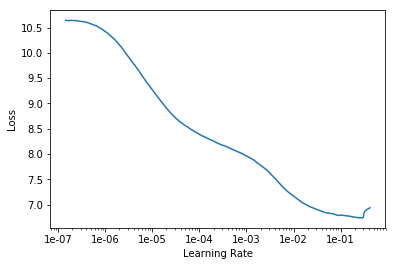

In [19]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(1, 1e-1, moms=(0.7,0.5))

epoch,train_loss,valid_loss,accuracy
1,6.460091,6.281972,0.116671


In [18]:
learn.fit_one_cycle(2, 1e-3, moms=(0.7,0.5))

epoch,train_loss,valid_loss,accuracy
1,6.487091,6.282309,0.116063
2,6.448372,6.262347,0.117127


In [20]:
learn.fit_one_cycle(12, 1e-3, moms=(0.7,0.5))

epoch,train_loss,valid_loss,accuracy


KeyboardInterrupt: 

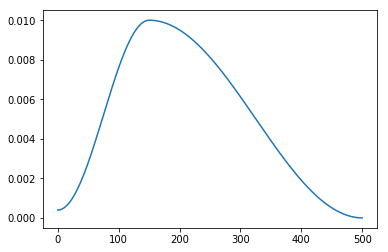

In [22]:
learn.recorder.plot_lr()

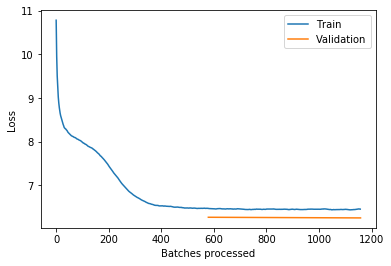

In [19]:
learn.recorder.plot_losses()

In [17]:
learn.save('transformer_run1_1en4');